In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('DataSet.csv', sep = ';').query('(X > 0) and (Y > 0) ')
df

,Номер карты,X,Y
0,7720466173,3168.05,1611.00
1,7705911749,6378.65,332.50
2,7725380531,716.00,390.00
3,7713420459,2319.40,1206.00
4,7719074177,2157.00,1886.00
...,...,...,...
361564,7700884547,4611.00,17895.00
361565,7724259178,19241.75,2844.00
361566,7719850006,29583.18,3930.97
361567,7721745834,3438.40,4947.50


(361306, 3)           X         Y
X  1.000000  0.482918
Y  0.482918  1.000000


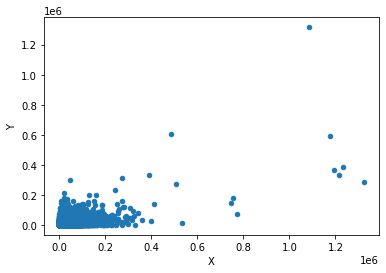

In [3]:
sample_df = df.sample(int(df.shape[0] * 1), random_state= 80)
sample_df.plot.scatter(x = 'X', y= 'Y')

print(sample_df.shape, sample_df[['X', 'Y']].corr())

In [4]:
df = sample_df

<AxesSubplot:xlabel='X', ylabel='Y'>

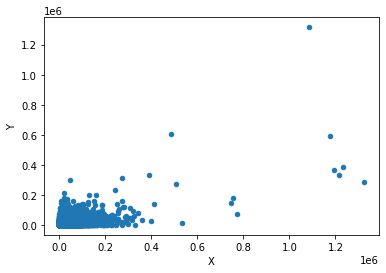

In [5]:
df.plot.scatter(x = 'X', y = 'Y')

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor

## Nominal Values

In [7]:
model_LSM = LinearRegression().fit(df[['X']].values, df[['Y']].values);
model_huber = HuberRegressor().fit(df[['X']].values, df[['Y']].values);

c:\Users\Kirill\.conda\envs\bayes\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
predicts_LSM = model_LSM.predict(df[['X']].values)
predicts_huber = model_huber.predict(df[['X']].values)

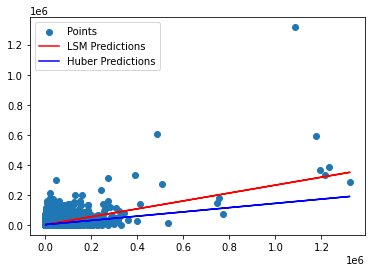

In [9]:
import matplotlib.pyplot as plt

plt.scatter(df[['X']].values, df[['Y']].values, label = 'Points')
plt.plot(df[['X']].values, predicts_LSM, label = 'LSM Predictions', color = 'red')
plt.plot(df[['X']].values, predicts_huber, label = 'Huber Predictions', color = 'blue')
plt.legend()

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.optimize import  minimize
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.patches as mpatches
from itertools import repeat




def Tukey(u, c_coef):
    f = lambda x: ( 1 - (1- (x / c_coef)**2 )**3 ) if np.abs(x) < c_coef else 1
    applyall = np.vectorize(f)
    return np.sum(applyall(u))



#Требуемая функция
def F(X, Y_true, weights = None, fit_c = True):
    X = X.reshape(len(X), -1)
    C = 1e5
    if weights is None:
            C = 1e5
            X0 = np.random.normal(0, 10, size = X.shape[1] + 2)
            X0[-1] = C
    else:
            Y_pred = weights[0]+np.sum(X * weights[1:], axis = 1)
            C = mean_absolute_error(Y_true, Y_pred)**(1/2)
            X0 = np.array(weights + [C]) 


    def Fit(coefs): 
        if not fit_c:
            coefs[-1] =  C
        Y_pred = np.sum(coefs[0]+X * coefs[1:-1], axis = 1) # y = b + x*a
        diff = (Y_true.reshape(1, -1) - Y_pred.reshape(1, -1))
        return Tukey(diff, c_coef = coefs[-1])
    
    #Зададим исходные веса, чтобы не попасть
    #в локальный минимум, используя midhinge для порога C
    
    #Минимизируем Tukey
    res = minimize(Fit, X0, method='L-BFGS-B') 
    return res 

In [11]:
init_tukey_weights = [model_LSM.intercept_[0]] + [model_LSM.coef_[0][0]]
init_tukey_weights

[2007.0325290294231, 0.26311754894076333]

In [12]:
X = df[['X']].values
Y = df[['Y']].values
#X = X.reshape(len(X), -1)
Y = Y.reshape(len(Y), -1)
coefs = F(X = X
    , Y_true = Y
    , weights= init_tukey_weights #LSM Weights
    , fit_c= True
    #, weights= model_huber.coef_.tolist() #Huber Weights
    )
coefs.x

array([2.00703253e+03, 2.63117549e-01, 5.34809153e+01])

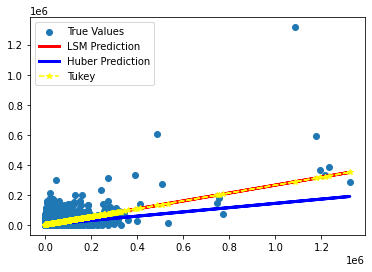

In [13]:
import matplotlib.pyplot as plt

plt.scatter(df[['X']].values, df[['Y']].values, label = 'True Values')
plt.plot(df[['X']].values, predicts_LSM, label = 'LSM Prediction', color = 'red', linewidth = 3)
plt.plot(df[['X']].values, predicts_huber, label = 'Huber Prediction', color = 'blue', linewidth = 3)
plt.plot(df[['X']].values, coefs.x[0] + np.sum(df[['X']].values * coefs.x[1:-1], axis = 1), '--*', label = 'Tukey', color = 'yellow')
plt.legend()

In [14]:
from sklearn.metrics import r2_score
print('R2 LSM ',r2_score(df[['Y']].values, predicts_LSM))
print('R2 Huber ',r2_score(df[['Y']].values, predicts_huber))
print('R2 Tukey ', r2_score(df[['Y']].values,  coefs.x[0] + np.sum(X * coefs.x[1:-1], axis = 1)))

R2 LSM  0.23320965461530607
R2 Huber  0.15494691230613644
R2 Tukey  0.23320965461530607


## PolyNominal Searching

In [15]:
from  copy import deepcopy as deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
results = {}
for p in np.arange(2, 20):
    try:
        #X = df[['X', 'Bias']].values
        df['NormX'] = (df['X'] - df['X'].mean()) / df['X'].std()
        X = df[['NormX']].values
        #X = df[['X']].values
        X = X.reshape(len(X), -1)

        X = PolynomialFeatures(degree = p, include_bias=False).fit_transform(X)#[:, -1]
        X = X.reshape(len(X), -1)
        X_train, X_test, Y_train, Y_test = train_test_split(X, df[['Y']].values, random_state=42)
        model_LSM = LinearRegression().fit(X_train, Y_train);
        model_huber = HuberRegressor().fit(X_train, Y_train);

        init_tukey_weights = model_LSM.intercept_.tolist() + np.squeeze(model_LSM.coef_).tolist()

        coefs = F(X = X_train
            , Y_true = np.squeeze(Y_train)
            , weights= init_tukey_weights #LSM Weights
            , fit_c= True
            #, weights= model_huber.coef_.tolist() #Huber Weights
            )
        
        predicts_LSM = model_LSM.predict(X_test)
        predicts_huber = model_huber.predict(X_test)
        
        res_p={}
        res_p['LSM R2']= r2_score(Y_test, predicts_LSM)
        res_p['Huber R2'] = r2_score(Y_test, predicts_huber)
        res_p['Tukey R2'] = r2_score(Y_test,  coefs.x[0] + np.sum(X_test * coefs.x[1:-1], axis = 1))

        res_p['Weights LSM'] = deepcopy(model_LSM)
        res_p['Weights Huber'] = deepcopy(model_huber)
        res_p['Model Tukey'] = deepcopy(coefs)

        results[p]= res_p
    except:
        continue    

c:\Users\Kirill\.conda\envs\bayes\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Kirill\.conda\envs\bayes\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Kirill\.conda\envs\bayes\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Kirill\.conda\envs\bayes\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

In [16]:
for r in results:
    print(f'Polynome {r} : ',results[r]['LSM R2'], results[r]['Huber R2'], results[r]['Tukey R2'])

Polynome 2 :  0.29244845610104475 0.23259943796908122 0.29244845610104475
Polynome 3 :  0.28840441887700363 -0.217556398552484 0.28840441887700363
Polynome 4 :  0.28435208592649475 -0.2218005603638855 0.28435208592649475
Polynome 5 :  0.23461357569700014 -0.22425455746678802 0.23461357569699992
Polynome 6 :  0.1800605107005635 -0.226462270019824 0.18006051070056894
Polynome 7 :  0.26703767018381275 -0.2912159625522057 0.2670376701838052
Polynome 8 :  0.2577096420491807 -0.2992061934946686 0.25770964204920055
Polynome 9 :  0.04961841274170742 -0.3066935521493175 0.04961841274479695
Polynome 10 :  0.09690192761765593 -0.3136800509589013 0.09690192761763228


In [17]:
best_LSM_p = sorted(results.items(), key = lambda x: -x[1]['LSM R2'])[0]
best_Huber_p = sorted(results.items(), key = lambda x: -x[1]['Huber R2'])[0]
best_Tukey_p = sorted(results.items(), key = lambda x: -x[1]['Tukey R2'])[0]

### Best LSM

C:\Users\Kirill\AppData\Local\Temp\ipykernel_12112\1737547350.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  XY = np.array(sorted(list(zip(df['X'].values, predicts_LSM)), key = lambda x: x[0]))


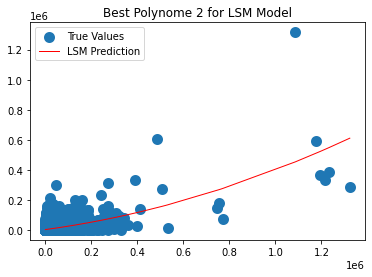

In [18]:
p = best_LSM_p[0]
X = df[['NormX']].values
#X = df[['X']].values
X = X.reshape(len(X), -1)

X = PolynomialFeatures(degree = p, include_bias=False).fit_transform(X)#[:, -1]
X = X.reshape(len(X), -1)

model_LSM = best_LSM_p[1]['Weights LSM']
predicts_LSM = model_LSM.predict(X)

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df['X'].values, df[['Y']].values, label = 'True Values', linewidths=5)

XY = np.array(sorted(list(zip(df['X'].values, predicts_LSM)), key = lambda x: x[0]))
plt.plot(XY.T[0] , XY.T[1], label = 'LSM Prediction', color = 'red', linewidth = 1)
plt.title(f'Best Polynome {p} for LSM Model')
plt.legend()
plt.show()

### Best Huber

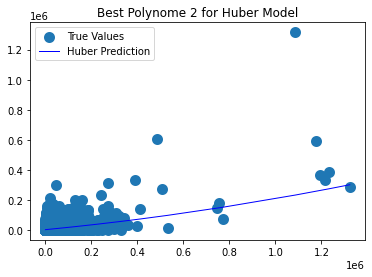

In [19]:
p = best_Huber_p[0]
X = df[['NormX']].values
#X = df[['X']].values
X = X.reshape(len(X), -1)

X = PolynomialFeatures(degree = p, include_bias=False).fit_transform(X)#[:, -1]
X = X.reshape(len(X), -1)

model_huber = best_Huber_p[1]['Weights Huber']
predicts_huber = model_huber.predict(X)


import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df['X'].values, df[['Y']].values, label = 'True Values', linewidths=5)

XY = np.array(sorted(list(zip(df['X'].values, predicts_huber)), key = lambda x: x[0]))
plt.plot(XY.T[0] , XY.T[1], label = 'Huber Prediction', color = 'blue', linewidth = 1)


plt.title(f'Best Polynome {p} for Huber Model')
plt.legend()
plt.show()

### Best Tukey

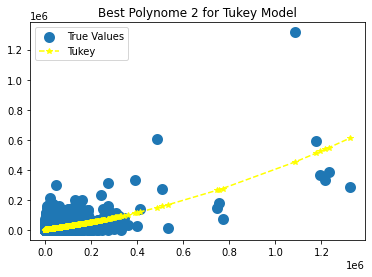

In [20]:
p = best_Tukey_p[0]
X = df[['NormX']].values
#X = df[['X']].values
X = X.reshape(len(X), -1)

X = PolynomialFeatures(degree = p, include_bias=False).fit_transform(X)#[:, -1]
X = X.reshape(len(X), -1)

coefs = best_Tukey_p[1]['Model Tukey']

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df['X'].values, df[['Y']].values, label = 'True Values', linewidths=5)


XY = np.array(  
                sorted(list(zip(df['X'].values.tolist()
                            ,  coefs.x[0]+np.sum(X * coefs.x[1:-1], axis = 1)))
                    , key = lambda x: x[0])
                    )
plt.plot(XY.T[0] , XY.T[1], '--*', label = 'Tukey', color = 'yellow')
plt.title(f'Best Polynome {p} for Tukey Model')
plt.legend()
plt.show()

### Best for each Model Together

C:\Users\Kirill\AppData\Local\Temp\ipykernel_12112\1194503027.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  XY = np.array(sorted(list(zip(df['X'].values, predicts_LSM)), key = lambda x: x[0]))


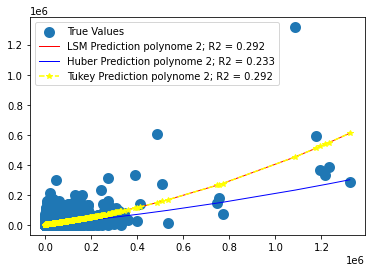

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df['X'].values, df[['Y']].values, label = 'True Values', linewidths=5)

XY = np.array(sorted(list(zip(df['X'].values, predicts_LSM)), key = lambda x: x[0]))
R2 = round(best_LSM_p[1]['LSM R2'], 3)
plt.plot(XY.T[0] , XY.T[1], label = f'LSM Prediction polynome {best_LSM_p[0]}; R2 = {R2}', color = 'red', linewidth = 1)

XY = np.array(sorted(list(zip(df['X'].values, predicts_huber)), key = lambda x: x[0]))
R2 = round(best_Huber_p[1]['Huber R2'], 3)
plt.plot(XY.T[0] , XY.T[1], label = f'Huber Prediction polynome {best_Huber_p[0]}; R2 = {R2}', color = 'blue', linewidth = 1)

XY = np.array(  
                sorted(list(zip(df['X'].values.tolist()
                            ,  coefs.x[0]+np.sum(X * coefs.x[1:-1], axis = 1)))
                    , key = lambda x: x[0])
                    )
R2 = round(best_Tukey_p[1]['Tukey R2'], 3)                    
plt.plot(XY.T[0] , XY.T[1], '--*', label = f'Tukey Prediction polynome {best_Tukey_p[0]}; R2 = {R2}', color = 'yellow')
plt.legend()